In [0]:
## imports and path

import matplotlib.pyplot as plt
import seaborn as sns
 
gold_flight_fact_path = "dbfs:/FileStore/vijay_project/gold/flight_fact"

sns.set_theme(style="whitegrid")
 
gold_path = gold_flight_fact_path

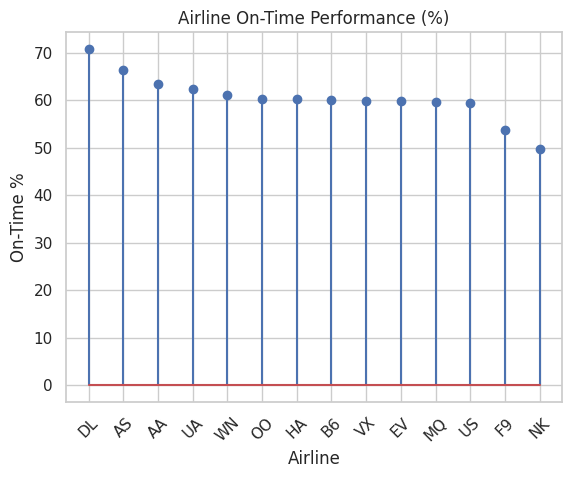

In [0]:

## Airline On-Time % (LOLLIPOP CHART)

df1 = spark.sql(f"""
SELECT AIRLINE_CODE,
ROUND(AVG(ON_TIME_FLAG)*100,2) AS ON_TIME_PERCENT
FROM delta.`{gold_path}`
GROUP BY AIRLINE_CODE
ORDER BY ON_TIME_PERCENT DESC
""").toPandas()
 
plt.figure()
plt.stem(df1["AIRLINE_CODE"], df1["ON_TIME_PERCENT"])
plt.title("Airline On-Time Performance (%)")
plt.xlabel("Airline")
plt.ylabel("On-Time %")
plt.xticks(rotation=45)
plt.show()

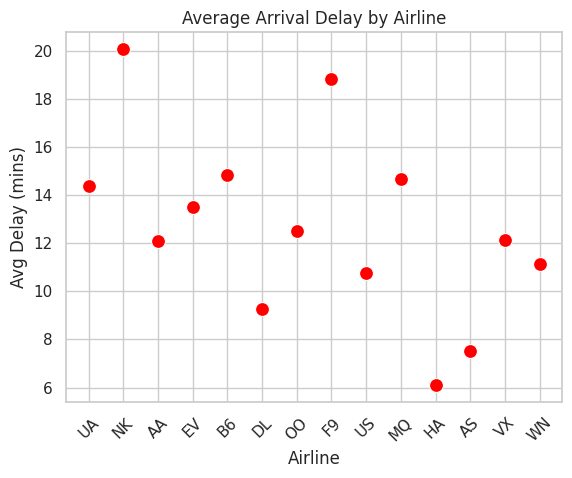

In [0]:

## Average Arrival Delay → SCATTER PLOT

df2 = spark.sql(f"""
SELECT AIRLINE_CODE,
ROUND(AVG(ARRIVAL_DELAY),2) AS AVG_DELAY
FROM delta.`{gold_path}`
GROUP BY AIRLINE_CODE
""").toPandas()
 
plt.figure()
sns.scatterplot(data=df2, x="AIRLINE_CODE", y="AVG_DELAY", color="red", s=100)
plt.title("Average Arrival Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Avg Delay (mins)")
plt.xticks(rotation=45)
plt.show()

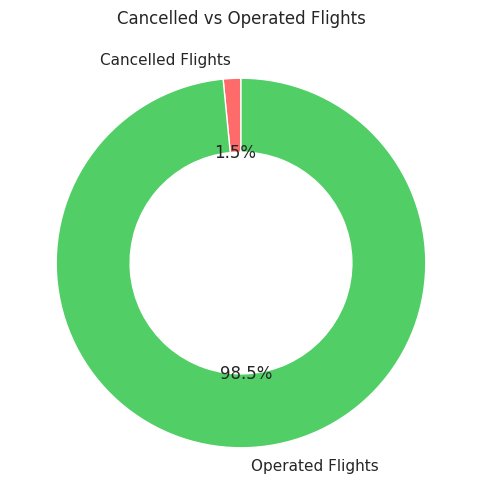

In [0]:

#  Cancellation Rate → DONUT CHART

df = spark.sql(f"""
SELECT
SUM(CASE WHEN CANCELLED = 1 THEN 1 ELSE 0 END) AS CANCELLED,
SUM(CASE WHEN CANCELLED = 0 THEN 1 ELSE 0 END) AS OPERATED
FROM delta.`{gold_flight_fact_path}`
""").toPandas()
 
plt.figure(figsize=(6,6))
plt.pie(
    df.iloc[0],
    labels=["Cancelled Flights", "Operated Flights"],
    autopct="%1.1f%%",
    colors=["#ff6b6b", "#51cf66"],
    wedgeprops=dict(width=0.4),
    startangle=90
)
plt.title("Cancelled vs Operated Flights")
plt.show()

/root/.ipykernel/1979/command-4997631501287578-3889817824:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df4, y="AIRLINE_CODE", x="DIVERSION_RATE", palette="mako")


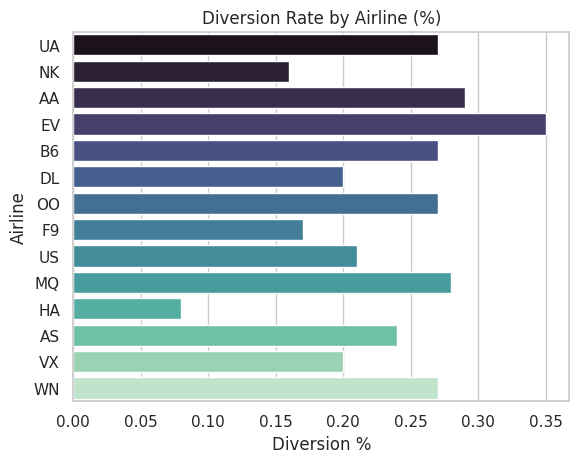

In [0]:

## Diversion Rate → HORIZONTAL BAR (DARK)

df4 = spark.sql(f"""
SELECT AIRLINE_CODE,
ROUND(SUM(DIVERTED)*100.0/COUNT(*),2) AS DIVERSION_RATE
FROM delta.`{gold_path}`
GROUP BY AIRLINE_CODE
""").toPandas()
 
plt.figure()
sns.barplot(data=df4, y="AIRLINE_CODE", x="DIVERSION_RATE", palette="mako")
plt.title("Diversion Rate by Airline (%)")
plt.xlabel("Diversion %")
plt.ylabel("Airline")
plt.show()

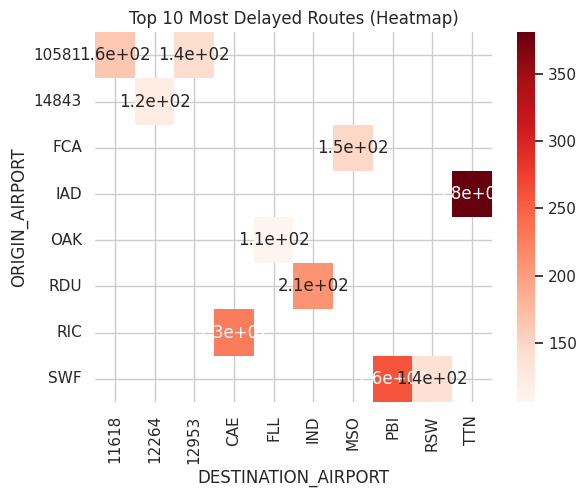

In [0]:

#  Top 10 Delayed Routes → HEATMAP

df5 = spark.sql(f"""
SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT,
ROUND(AVG(ARRIVAL_DELAY),2) AS AVG_DELAY
FROM delta.`{gold_path}`
GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT
ORDER BY AVG_DELAY DESC
LIMIT 10
""").toPandas()
 
pivot = df5.pivot(index="ORIGIN_AIRPORT", columns="DESTINATION_AIRPORT", values="AVG_DELAY")
 
plt.figure()
sns.heatmap(pivot, annot=True, cmap="Reds")
plt.title("Top 10 Most Delayed Routes (Heatmap)")
plt.show()

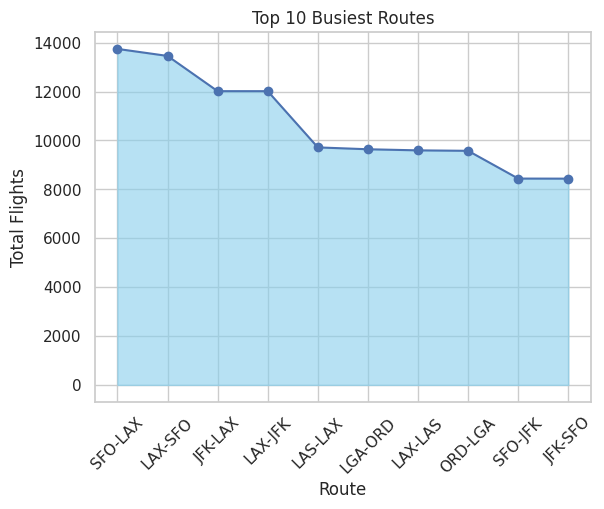

In [0]:

# Busiest Routes → AREA CHART

df6 = spark.sql(f"""
SELECT ORIGIN_AIRPORT || '-' || DESTINATION_AIRPORT AS ROUTE,
COUNT(*) AS TOTAL_FLIGHTS
FROM delta.`{gold_path}`
GROUP BY ROUTE
ORDER BY TOTAL_FLIGHTS DESC
LIMIT 10
""").toPandas()
 
plt.figure()
plt.fill_between(df6["ROUTE"], df6["TOTAL_FLIGHTS"], color="skyblue", alpha=0.6)
plt.plot(df6["ROUTE"], df6["TOTAL_FLIGHTS"], marker='o')
plt.title("Top 10 Busiest Routes")
plt.xlabel("Route")
plt.ylabel("Total Flights")
plt.xticks(rotation=45)
plt.show()

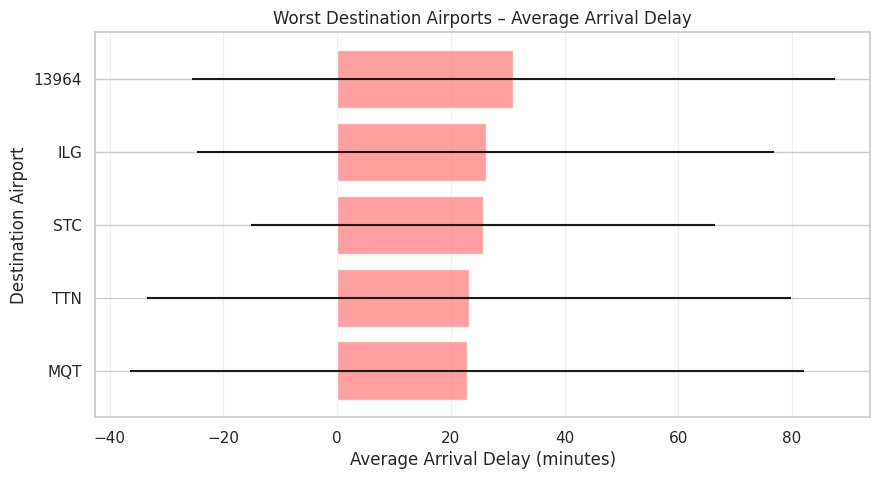

In [0]:

#  Aggregate delay statistics for destination airports → HORIZONTAL BAR CHART

df7 = spark.sql(f"""
SELECT
    DESTINATION_AIRPORT,
    AVG(ARRIVAL_DELAY) AS AVG_DELAY,
    STDDEV(ARRIVAL_DELAY) AS STD_DELAY
FROM delta.`{gold_path}`
WHERE ARRIVAL_DELAY IS NOT NULL
GROUP BY DESTINATION_AIRPORT
ORDER BY AVG_DELAY DESC
LIMIT 5
""").toPandas()
 
plt.figure(figsize=(10,5))
 
plt.barh(
    df7["DESTINATION_AIRPORT"],
    df7["AVG_DELAY"],
    xerr=df7["STD_DELAY"],
    color="#ff8787",
    alpha=0.8
)
 
plt.gca().invert_yaxis()
plt.title("Worst Destination Airports – Average Arrival Delay")
plt.xlabel("Average Arrival Delay (minutes)")
plt.ylabel("Destination Airport")
 
plt.grid(axis="x", alpha=0.3)
plt.show()

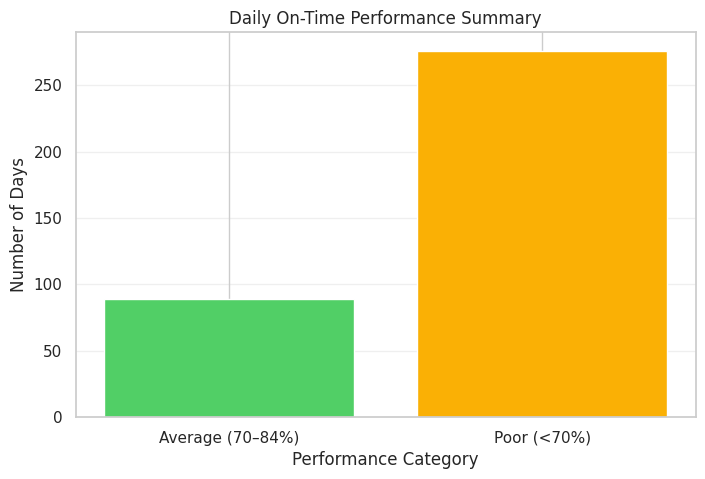

In [0]:

#  Daily On-Time Trend → BUCKETED BAR CHART

import pandas as pd
df8 = spark.sql(f"""
SELECT
    FLIGHT_DATE,
    ROUND(AVG(ON_TIME_FLAG)*100,2) AS ON_TIME_PERCENT
FROM delta.`{gold_path}`
GROUP BY FLIGHT_DATE
""").toPandas()
 
def performance_bucket(x):
    if x >= 85:
        return "Good (>=85%)"
    elif x >= 70:
        return "Average (70–84%)"
    else:
        return "Poor (<70%)"
 
df8["PERFORMANCE_BUCKET"] = df8["ON_TIME_PERCENT"].apply(performance_bucket)
 
bucket_summary = (
    df8.groupby("PERFORMANCE_BUCKET")
      .size()
      .reset_index(name="NUMBER_OF_DAYS")
)
 
bucket_order = ["Good (>=85%)", "Average (70–84%)", "Poor (<70%)"]
bucket_summary["PERFORMANCE_BUCKET"] = pd.Categorical(
    bucket_summary["PERFORMANCE_BUCKET"],
    categories=bucket_order,
    ordered=True
)
bucket_summary = bucket_summary.sort_values("PERFORMANCE_BUCKET")
 
plt.figure(figsize=(8,5))
plt.bar(
    bucket_summary["PERFORMANCE_BUCKET"],
    bucket_summary["NUMBER_OF_DAYS"],
    color=["#51cf66", "#fab005", "#ff6b6b"]
)
 
plt.title("Daily On-Time Performance Summary")
plt.xlabel("Performance Category")
plt.ylabel("Number of Days")
plt.grid(axis="y", alpha=0.3)
 
plt.show()

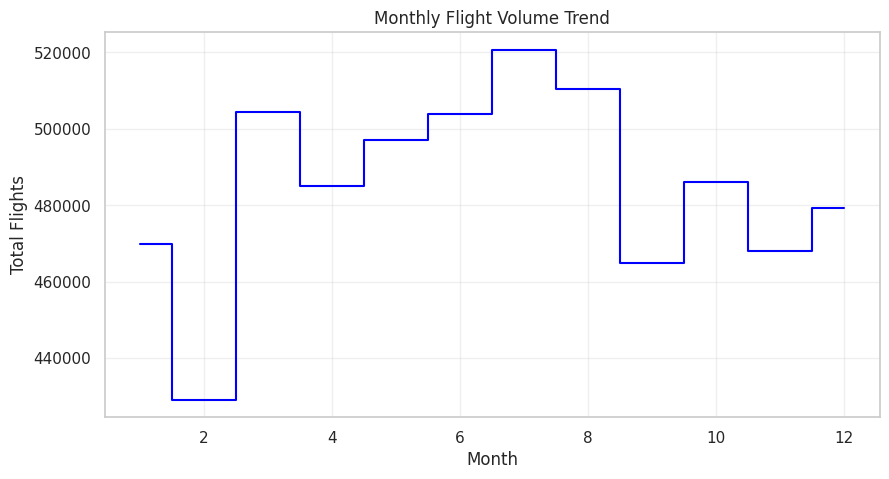

In [0]:

#  Monthly Volume → Step chart

df9 = spark.sql(f"""
SELECT month(FLIGHT_DATE) AS MONTH,
COUNT(*) AS TOTAL_FLIGHTS
FROM delta.`{gold_flight_fact_path}`
GROUP BY MONTH
ORDER BY MONTH
""").toPandas()
 
plt.figure(figsize=(10,5))
plt.step(df9["MONTH"], df9["TOTAL_FLIGHTS"], where="mid", color="blue")
plt.title("Monthly Flight Volume Trend")
plt.xlabel("Month")
plt.ylabel("Total Flights")
plt.grid(alpha=0.3)
plt.show()

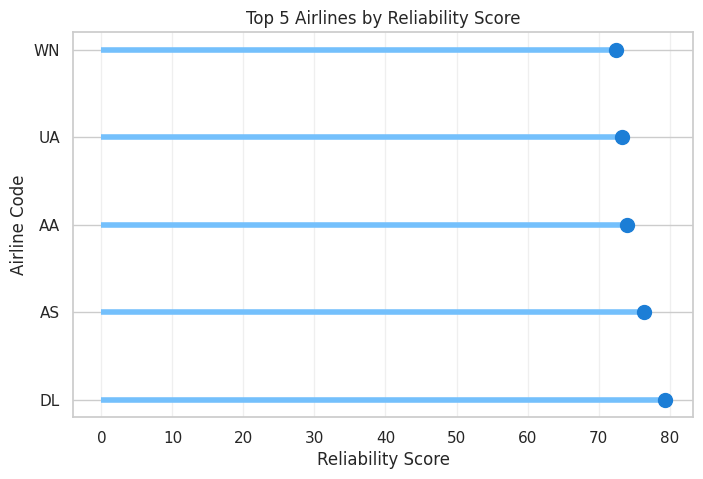

In [0]:

#  Airline Reliability → RANKED LOLLIPOP CHART (or DOT PLOT).

df10 = spark.sql(f"""
SELECT AIRLINE_CODE,
ROUND(
    (AVG(ON_TIME_FLAG) * 0.7 +
     (1 - AVG(CANCEL_FLAG)) * 0.3) * 100, 2
) AS RELIABILITY_SCORE
FROM delta.`{gold_path}`
GROUP BY AIRLINE_CODE
ORDER BY RELIABILITY_SCORE DESC
LIMIT 5
""").toPandas()
 
plt.figure(figsize=(8,5))
 
plt.hlines(
    y=df10["AIRLINE_CODE"],
    xmin=0,
    xmax=df10["RELIABILITY_SCORE"],
    color="#74c0fc",
    linewidth=4
)
 
plt.plot(
    df10["RELIABILITY_SCORE"],
    df10["AIRLINE_CODE"],
    "o",
    color="#1c7ed6",
    markersize=10
)
 
plt.title("Top 5 Airlines by Reliability Score")
plt.xlabel("Reliability Score")
plt.ylabel("Airline Code")
plt.grid(axis="x", alpha=0.3)
 
plt.show()

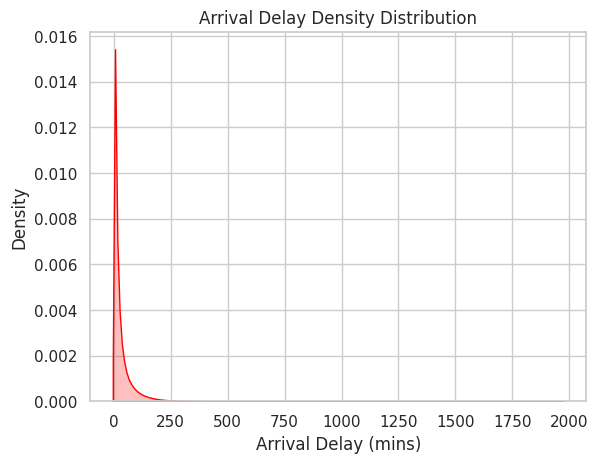

In [0]:

#  Arrival Delay Distribution → KDE

df11 = spark.sql(f"""
SELECT ARRIVAL_DELAY
FROM delta.`{gold_path}`
WHERE ARRIVAL_DELAY IS NOT NULL
""").toPandas()
 
plt.figure()
sns.kdeplot(df11["ARRIVAL_DELAY"], fill=True, color="red")
plt.title("Arrival Delay Density Distribution")
plt.xlabel("Arrival Delay (mins)")
plt.show()

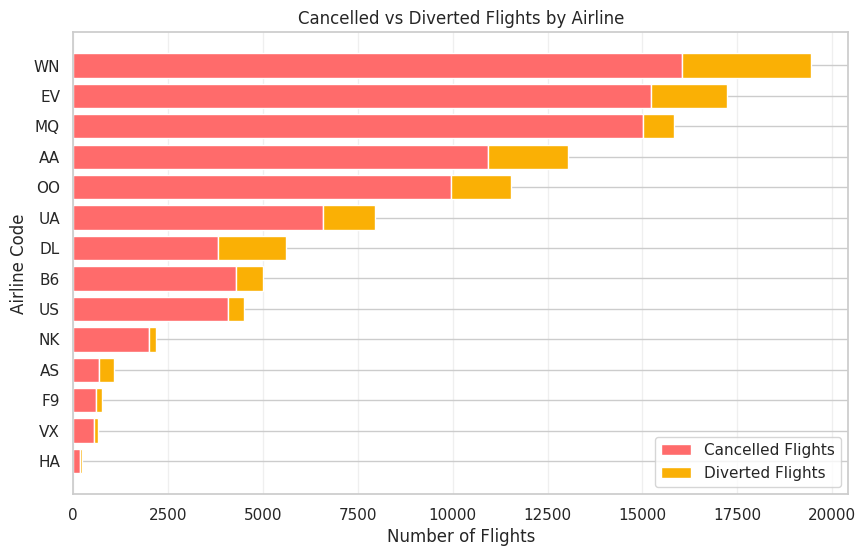

In [0]:

#  Aggregate cancellation & diversion counts - harizontal bar chart

df12 = spark.sql(f"""
SELECT
    AIRLINE_CODE,
    SUM(CANCELLED) AS CANCELLED_FLIGHTS,
    SUM(DIVERTED) AS DIVERTED_FLIGHTS
FROM delta.`{gold_path}`
GROUP BY AIRLINE_CODE
ORDER BY (SUM(CANCELLED) + SUM(DIVERTED)) DESC
""").toPandas()
 
plt.figure(figsize=(10,6))
 
plt.barh(
    df12["AIRLINE_CODE"],
    df12["CANCELLED_FLIGHTS"],
    label="Cancelled Flights",
    color="#ff6b6b"
)
 
plt.barh(
    df12["AIRLINE_CODE"],
    df12["DIVERTED_FLIGHTS"],
    left=df12["CANCELLED_FLIGHTS"],
    label="Diverted Flights",
    color="#fab005"
)
 
plt.title("Cancelled vs Diverted Flights by Airline")
plt.xlabel("Number of Flights")
plt.ylabel("Airline Code")
plt.legend()
plt.grid(axis="x", alpha=0.3)
 
plt.gca().invert_yaxis()
plt.show()
 